In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pwt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

In [ ]:
path= ''
df= pd.read_csv(path)

In [ ]:
raw_data = df.values

In [ ]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]


In [ ]:
# Wavelet filtering
coeffs = pywt.wavedec(data, 'db4', level=1)
threshold = np.std(coeffs[-1]) * np.sqrt(2*np.log(len(data)))
coeffs[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeffs[1:])
data = pywt.waverec(coeffs, 'db4')


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [ ]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

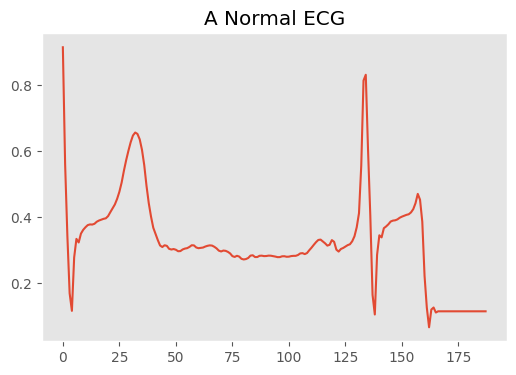

In [ ]:
plt.grid()
plt.plot(np.arange(188), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

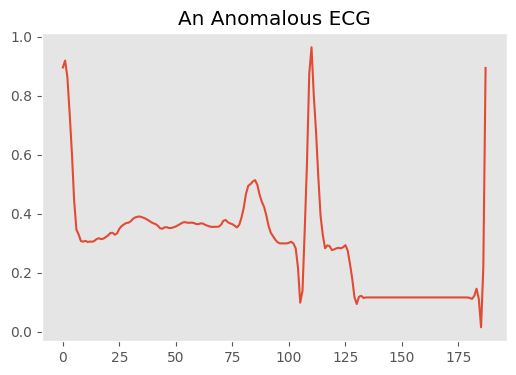

In [ ]:
plt.grid()
plt.plot(np.arange(188), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(40, activation="relu"),
      layers.Dense(20, activation="relu"),
      layers.Dense(10, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(20, activation="relu"),
      layers.Dense(40, activation="relu"),
      layers.Dense(188, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=80,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 473ms/step - accuracy: 0.0000e+00 - loss: 0.6925 - val_accuracy: 0.0000e+00 - val_loss: 0.6878
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 7.7954e-05 - loss: 0.6850 - val_accuracy: 0.0014 - val_loss: 0.6727
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 8.4486e-04 - loss: 0.6653 - val_accuracy: 0.0014 - val_loss: 0.6449
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0016 - loss: 0.6304 - val_accuracy: 0.0399 - val_loss: 0.6204
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0092 - loss: 0.5971 - val_accuracy: 0.0402 - val_loss: 0.6098
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0189 - loss: 0.5757 - val_accuracy: 0.7254 - val_loss: 0.5848
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9308 - loss: 0.5582 - val_accuracy: 0.7254 - val_loss: 0.5740
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9308 - loss: 0.5491 - val_accuracy: 0.7254 - 

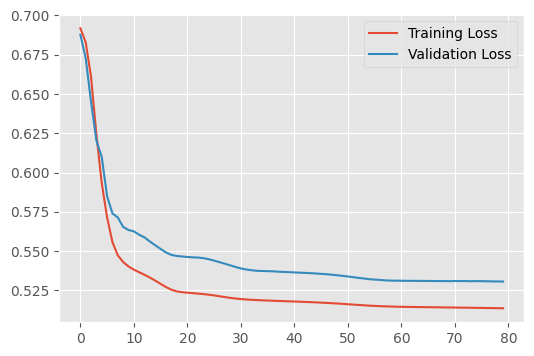

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

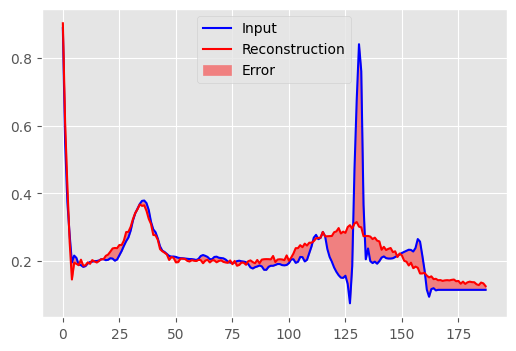

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

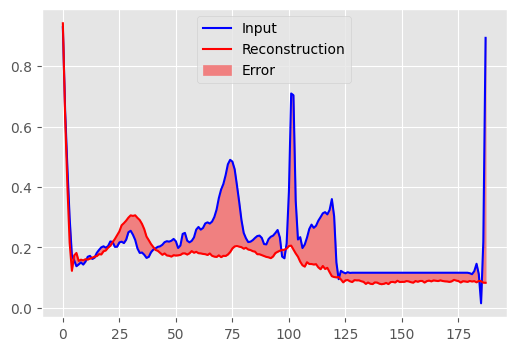

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


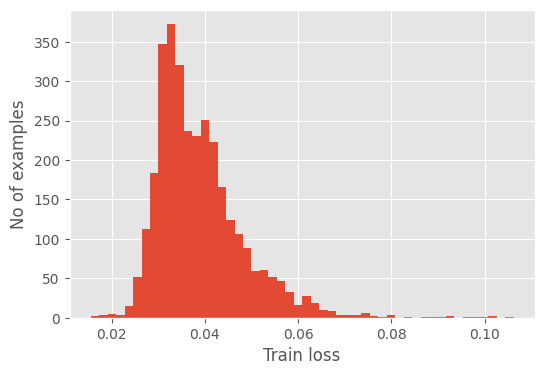

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.048476916


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


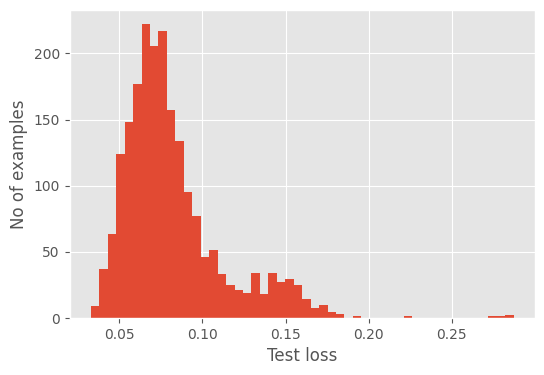

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.9137457044673539
Precision = 0.8610086100861009
Recall = 0.8353221957040573


In [ ]:
def print_stats(predictions, labels):
    conf_mat = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)

    auc_score = roc_auc_score(labels, predictions)
    print("AUC Score:", auc_score)
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Confusion Matrix:
[[1959  113]
 [ 138  700]]
AUC Score: 0.8903927580836889
Accuracy: 0.9137457044673539
Precision: 0.8610086100861009
Recall: 0.8353221957040573
F1 Score: 0.8479709267110842


** *****2eme architecture**

In [ ]:
class AnomalyDetector2(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector2, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(16, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.2),
            layers.Dense(188, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector2()

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=80,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 7.3842e-04 - loss: 0.6496 - val_accuracy: 0.0000e+00 - val_loss: 0.6278
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6052 - loss: 0.6034 - val_accuracy: 0.7254 - val_loss: 0.5972
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9372 - loss: 0.5689 - val_accuracy: 0.7254 - val_loss: 0.5746
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9359 - loss: 0.5497 - val_accuracy: 0.7254 - val_loss: 0.5697
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9310 - loss: 0.5427 - val_accuracy: 0.7254 - val_loss: 0.5631
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9356 - loss: 0.5382 - val_accuracy: 0.7254 - val_loss: 0.5618
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9347 - loss: 0.5351 - val_accuracy: 0.7254 - val_loss: 0.5576
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9367 - loss: 0.5327 - val_accuracy: 0.7254 - val_loss:

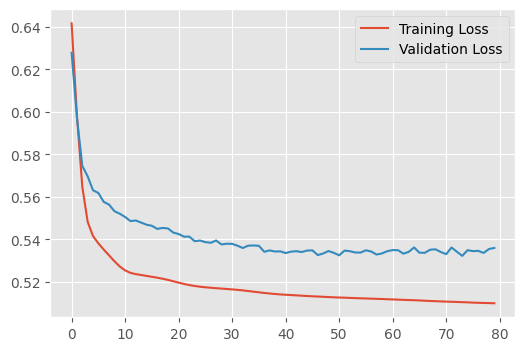

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

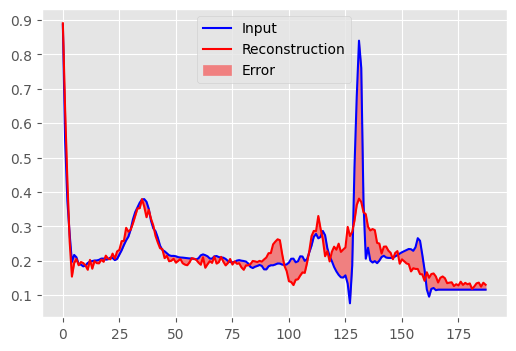

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

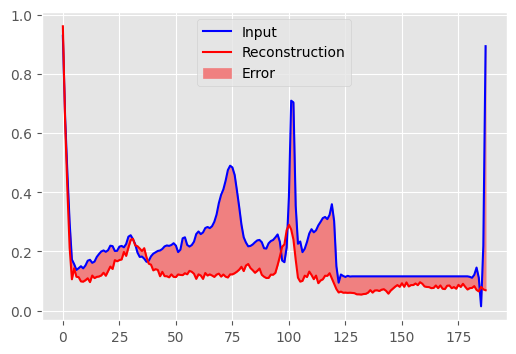

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


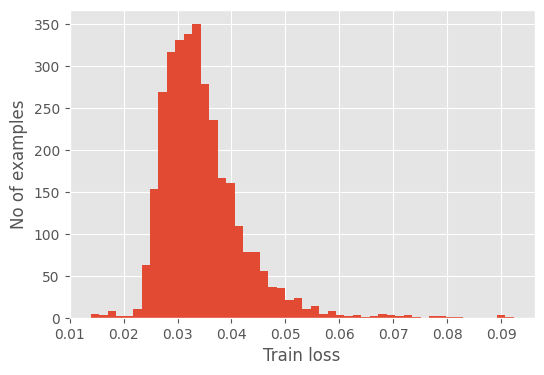

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.042146467


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


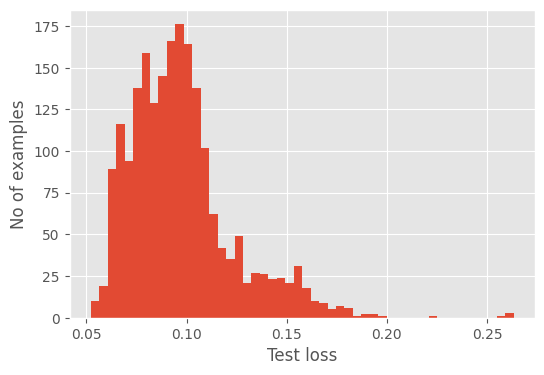

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.9580756013745705
Precision = 1.0
Recall = 0.8544152744630071


In [ ]:
def print_stats(predictions, labels):
    # Confusion Matrix
    conf_mat = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)

    # AUC Calculation
    auc_score = roc_auc_score(labels, predictions)
    print("AUC Score:", auc_score)

    # Additional Metrics
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Confusion Matrix:
[[2072    0]
 [ 122  716]]
AUC Score: 0.9272076372315036
Accuracy: 0.9580756013745705
Precision: 1.0
Recall: 0.8544152744630071
F1 Score: 0.9214929214929215


**3éme Architecture**

In [ ]:
class AnomalyDetector3(tf.keras.Model):
    def __init__(self):
        super(AnomalyDetector3, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(32, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.3),
            layers.Dense(188, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector3()


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=80,
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.0000e+00 - loss: 0.6859 - val_accuracy: 0.0000e+00 - val_loss: 0.6510
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0395 - loss: 0.6295 - val_accuracy: 0.6395 - val_loss: 0.6194
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8676 - loss: 0.5745 - val_accuracy: 0.7254 - val_loss: 0.5755
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9330 - loss: 0.5468 - val_accuracy: 0.7254 - val_loss: 0.5707
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9352 - loss: 0.5417 - val_accuracy: 0.7254 - val_loss: 0.5661
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9380 - loss: 0.5387 - val_accuracy: 0.7254 - val_loss: 0.5641
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9347 - loss: 0.5353 - val_accuracy: 0.7254 - val_loss: 0.5591
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9329 - loss: 0.5329 - val_accuracy: 0.7254 - val_loss: 0.5

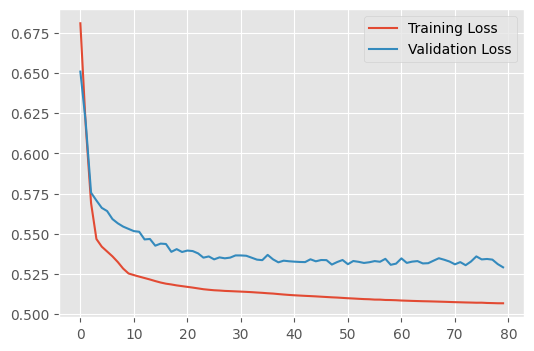

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

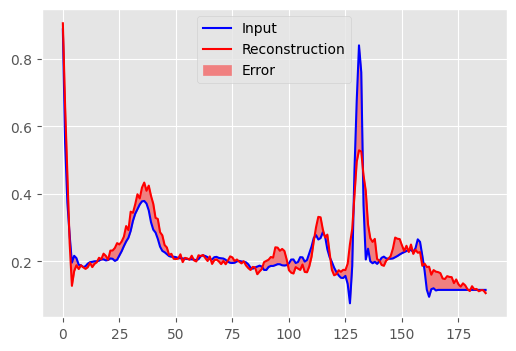

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

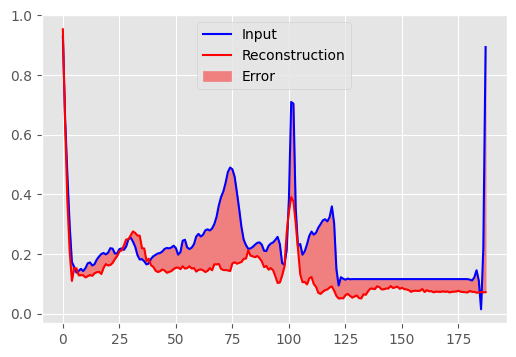

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(188), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


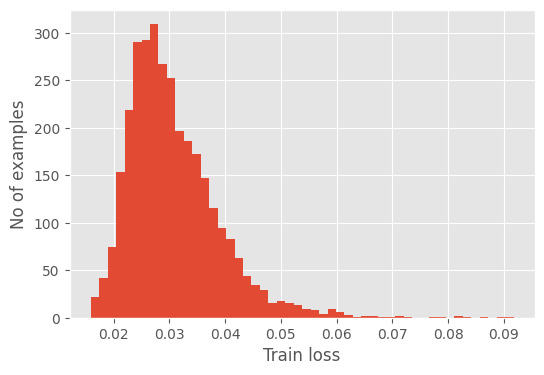

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.039160434


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


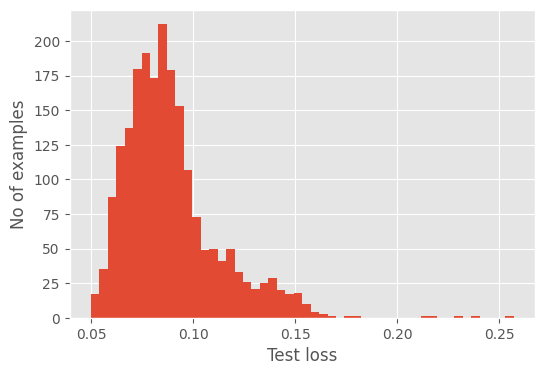

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.9532646048109966
Precision = 1.0
Recall = 0.837708830548926


In [ ]:
def print_stats(predictions, labels):
    # Confusion Matrix
    conf_mat = confusion_matrix(labels, predictions)
    print("Confusion Matrix:")
    print(conf_mat)


    auc_score = roc_auc_score(labels, predictions)
    print("AUC Score:", auc_score)
    print("Accuracy:", accuracy_score(labels, predictions))
    print("Precision:", precision_score(labels, predictions))
    print("Recall:", recall_score(labels, predictions))
    print("F1 Score:", f1_score(labels, predictions))  # Calculate and print F1-score

# Generate predictions
preds = predict(autoencoder, test_data, threshold)

# Print statistics
print_stats(preds, test_labels)

Confusion Matrix:
[[2072    0]
 [ 136  702]]
AUC Score: 0.918854415274463
Accuracy: 0.9532646048109966
Precision: 1.0
Recall: 0.837708830548926
F1 Score: 0.9116883116883117
